In [101]:
from vtl.Readfile import Readfile
from vtl.Photo import Photometry
from spec_id import Analyze_LH_lwa, Error,Oldest_galaxy, Gen_spec, Stack, \
    Median_w_Error,Median_w_Error_cont,Likelihood_contours,Gen_sim, Stack_posteriors, Linear_fit , \
    Median_w_Error_95,Gen_grid, Iterative_stacking, Gauss_dist
from astropy.table import Table
from astropy.io import fits
import astropy.units as u
import os
from astropy.cosmology import Planck13, z_at_value
from scipy.interpolate import interp1d, interp2d
from scipy.ndimage import interpolation
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors
from matplotlib.ticker import AutoMinorLocator
import matplotlib.patheffects as PathEffects
from mpl_toolkits.axes_grid.inset_locator import inset_axes
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
from glob import glob
import seaborn as sea
import numpy as np
import pandas as pd
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
colors = [(0,i,i,i) for i in np.linspace(0,1,3)]
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.2, as_cmap=True)
pandas2ri.activate()

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

In [98]:
galDB = pd.read_pickle('../data/upd_galDB.pkl')
lzDB = galDB.query('z_grism < 1.16')
mzDB = galDB.query('1.16 < z_grism < 1.3')
hzDB = galDB.query('1.3 < z_grism < 1.45')
uhzDB = galDB.query('1.45 < z_grism')


metal=np.round(np.arange(0.002,0.031,0.001),3)
age=np.round(np.arange(.5,6.1,.1),1)
tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]
dust=np.round(np.arange(0.0,1.1,0.1),1)
M,A=np.meshgrid(metal,age)

# UVJ plot

In [99]:
###DATA 
uvjDB = pd.read_pickle('../data/uvj_db.pkl')
s_cand = pd.read_pickle('../data/S_allspec_info')
n_cand = pd.read_pickle('../data/N_allspec_info')

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))


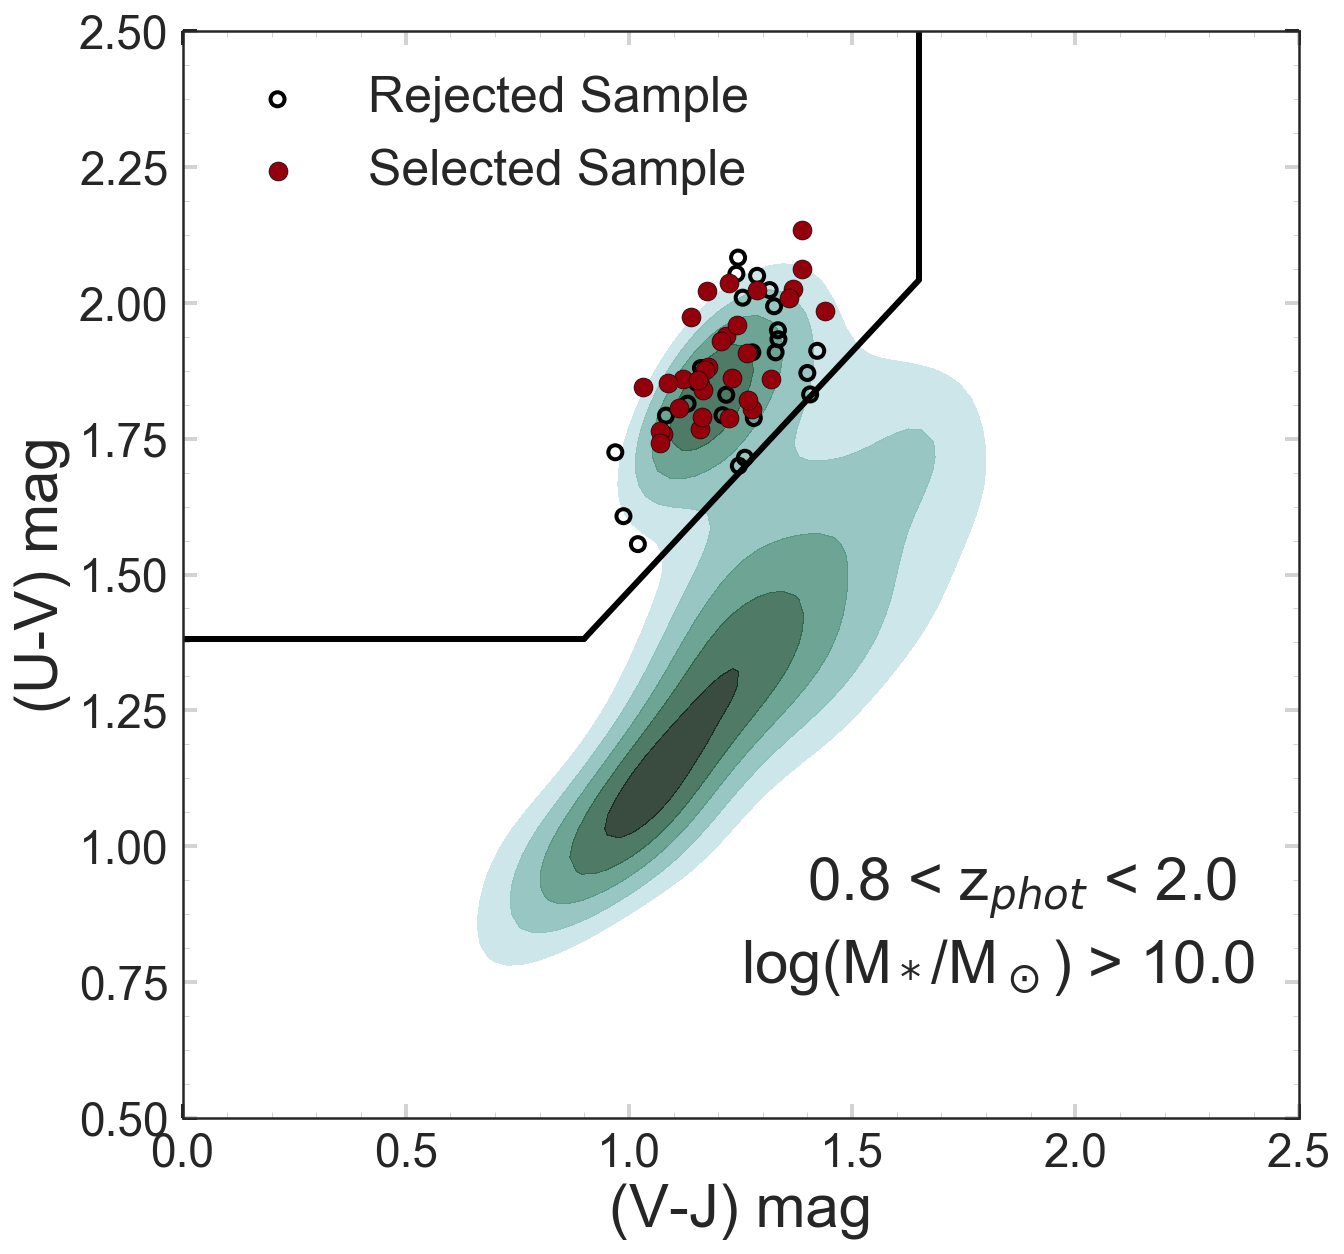

In [100]:
###PLOTS
%matplotlib inline

plt.figure(figsize=[10,10])
sea.kdeplot(uvjDB['(V-J)'],uvjDB['(U-V)'],n_levels = 7,alpha = .8,shade=True,cmap=cmap,kernel= 'epa',zorder=1)
plt.scatter(s_cand.query('goodspec == "out"').VJ,s_cand.query('goodspec == "out"').UV,
            facecolor='none',edgecolors='k',linewidth=2, label = 'Rejected Sample')
plt.scatter(n_cand.query('goodspec == "out"').VJ,n_cand.query('goodspec == "out"').UV.values,
            facecolor='none',edgecolors='k',linewidth=2)
plt.scatter(s_cand.query('goodspec == "in"').VJ,s_cand.query('goodspec == "in"').UV,edgecolors='k',color='#93000B',s=90, label = 'Selected Sample')
plt.scatter(n_cand.query('goodspec == "in"').VJ,n_cand.query('goodspec == "in"').UV.values,edgecolors='k',color='#93000B',s=90)

plt.plot([0,.9],[1.382,1.382],'k',lw=.9,linewidth=3)
plt.plot([1.65,1.65],[2.045,2.5],'k',lw=.9,linewidth=3)
plt.plot([.9,1.65],[0.88*.9+0.59,0.88*1.65+0.59],'k',lw=.9,linewidth=3)
plt.axis([0,2.5,.5,2.5])
plt.legend(loc=2,fontsize=25)
plt.text(1.4,0.90,'0.8 < z$_{phot}$ < 2.0', fontsize = 30)
plt.text(1.25,0.75,'log(M$_*$/M$_\odot$) > 10.0', fontsize = 30)
plt.xlabel('(V-J) mag',fontsize=30)
plt.ylabel('(U-V) mag',fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=23,length = 7, width=2)
plt.minorticks_on()
plt.savefig('../plots/uvj_kde_plot_8-13.pdf',bbox_inches = 'tight')

In [58]:
all_S_list = glob('/Volumes/Vince_research/Extractions/Updated_Q_gals/*S*')
all_N_list = glob('/Volumes/Vince_research/Extractions/Updated_Q_gals/*N*')

In [59]:
SIDS=[]
NIDS=[]

for i in range(len(all_S_list)):
    SIDS.append(os.path.basename(all_S_list[i]).split('_')[-1])

for i in range(len(all_N_list)):
    if 'D' not in os.path.basename(all_N_list[i]):
        NIDS.append(os.path.basename(all_N_list[i]).split('_')[-1])

In [60]:
SIDS=np.array(list(set(SIDS))).astype(int)
NIDS=np.array(list(set(NIDS))).astype(int)

In [61]:
# goods_s=Table.read(hpath + 'Clear_data/goodss_mosaic/goodss_3dhst.v4.3.cat',format='ascii').to_pandas()
# goods_n=Table.read(hpath + 'Clear_data/goodsn_mosaic/goodsn_3dhstP.cat',format='ascii').to_pandas()

# if hpath == '/Users/Vince.ec/':
#     catpath = hpath
# else:
#     catpath='/Users/vestrada/Desktop/'

# restc_s=Table.read(catpath + 'catalogs_for_CLEAR/goodss_3dhst.v4.1.cats/RF_colors/goodss_3dhst.v4.1.master.RF',format='ascii').to_pandas()
# restc_n=Table.read(catpath + 'catalogs_for_CLEAR/goodsn_3dhst.v4.1.cats/RF_colors/goodsn_3dhst.v4.1.master.RF',format='ascii').to_pandas()

# fast_s=Table.read(catpath + 'catalogs_for_CLEAR/goodss_3dhst.v4.1.cats/Fast/goodss_3dhst.v4.1.fout',format='ascii').to_pandas()
# fast_n=Table.read(catpath + 'catalogs_for_CLEAR/goodsn_3dhst.v4.1.cats/Fast/goodsn_3dhst.v4.1.fout',format='ascii').to_pandas()

# eazy_s = Table.read(catpath + 'catalogs_for_CLEAR/goodss_3dhst.v4.1.cats/Eazy/goodss_3dhst.v4.1.zout',
#                format = 'ascii').to_pandas()
# eazy_n = Table.read(catpath + 'catalogs_for_CLEAR/goodsn_3dhst.v4.1.cats/Eazy/goodsn_3dhst.v4.1.zout',
#                format = 'ascii').to_pandas()

def Mag(band):
    magnitude=25-2.5*np.log10(band)
    return magnitude

uvS=Mag(restc_s['L153'][SIDS-1].values) - Mag(restc_s['L155'][SIDS-1].values)
vjS=Mag(restc_s['L155'][SIDS-1].values) - Mag(restc_s['L161'][SIDS-1].values)
uvN=Mag(restc_n['L153'][NIDS-1].values) - Mag(restc_n['L155'][NIDS-1].values)
vjN=Mag(restc_n['L155'][NIDS-1].values) - Mag(restc_n['L161'][NIDS-1].values)
                    
Srshift_s = eazy_s.z_spec[SIDS-1]
Srshift_p = eazy_s.z_peak[SIDS-1]
Nrshift_s = eazy_n.z_spec[NIDS-1]
Nrshift_p = eazy_n.z_peak[NIDS-1]

In [62]:
s_cand = pd.DataFrame({'ids':SIDS, 'UV':uvS, 'VJ':vjS, 'zphot':Srshift_p, 'zspec':Srshift_s})
n_cand = pd.DataFrame({'ids':NIDS, 'UV':uvN, 'VJ':vjN, 'zphot':Nrshift_p, 'zspec':Nrshift_s})

In [63]:
s_AFspec = glob('/Volumes/Vince_research/Extractions/Updated_Q_gals/stack_specs/s*')
n_AFspec = glob('/Volumes/Vince_research/Extractions/Updated_Q_gals/stack_specs/n*')

In [64]:
s_Aspec = [int(os.path.basename(U)[1:6]) for U in s_AFspec]
n_Aspec = [int(os.path.basename(U)[1:6]) for U in n_AFspec]

In [65]:
s_cand['allspec'] = np.repeat('out',len(s_cand))
n_cand['allspec'] = np.repeat('out',len(n_cand))

for i in s_cand.index:
    if s_cand.ids[i] in s_Aspec:
        s_cand.allspec[i] = 'in'
        
for i in n_cand.index:
    if n_cand.ids[i] in n_Aspec:
        n_cand.allspec[i] = 'in'

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [67]:
s_cand = s_cand.query("allspec == 'in'")
n_cand = n_cand.query("allspec == 'in'")

In [81]:
gFspec = galDB.gids.values

In [83]:
s_gspec = [int(os.path.basename(U)[1:6]) for U in s_gFspec]
n_gspec = [int(os.path.basename(U)[1:6]) for U in n_gFspec]

In [84]:
s_cand['goodspec'] = np.repeat('out',len(s_cand))
n_cand['goodspec'] = np.repeat('out',len(n_cand))

for i in s_cand.index:
    if s_cand.ids[i] in s_gspec:
        s_cand.goodspec[i] = 'in'
        
for i in n_cand.index:
    if n_cand.ids[i] in n_gspec:
        n_cand.goodspec[i] = 'in'

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Re

In [171]:
# s_cand.to_pickle('../data/S_allspec_info')
# n_cand.to_pickle('../data/N_allspec_info')

In [143]:
s_cand['l_mass'] = fast_s.lmass[s_cand.ids.values -1].values
n_cand['l_mass'] = fast_n.lmass[n_cand.ids.values -1].values

# Signal to Noise plot

In [121]:
def Sig_int(er):
    sig = np.zeros(len(er)-1)
    
    for i in range(len(er)-1):
        sig[i] = np.sqrt(er[i]**2 + er[i+1]**2 )
    
    return np.sum((1/2)*sig)


def SN(wv,fl,er):
    IDX = [U for U in range(len(wv)) if 7900 < wv[U] < 11100]
    return np.trapz(fl[IDX])/ Sig_int(er[IDX])

In [134]:
s_cand['SNR'] = np.zeros(len(s_cand))
n_cand['SNR'] = np.zeros(len(n_cand))

for i in s_cand.index:
    wv,fl,er = np.load('/Volumes/Vince_research/Extractions/Updated_Q_gals/stack_specs/s{0}.npy'.format(s_cand.ids[i]))
    s_cand['SNR'][i] = SN(wv[fl > 0],fl[fl > 0],er[fl > 0])
        
for i in n_cand.index:
    wv,fl,er = np.load('/Volumes/Vince_research/Extractions/Updated_Q_gals/stack_specs/n{0}.npy'.format(n_cand.ids[i]))
    n_cand['SNR'][i] = SN(wv[fl > 0],fl[fl > 0],er[fl > 0])

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [138]:
galDB['SNR'] = np.zeros(len(galDB))

for i in galDB.index:
    wv,fl,er = np.load('../spec_stacks/{0}.npy'.format(galDB.gids[i]))
    galDB['SNR'][i] = SN(wv[fl > 0],fl[fl > 0],er[fl > 0])

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


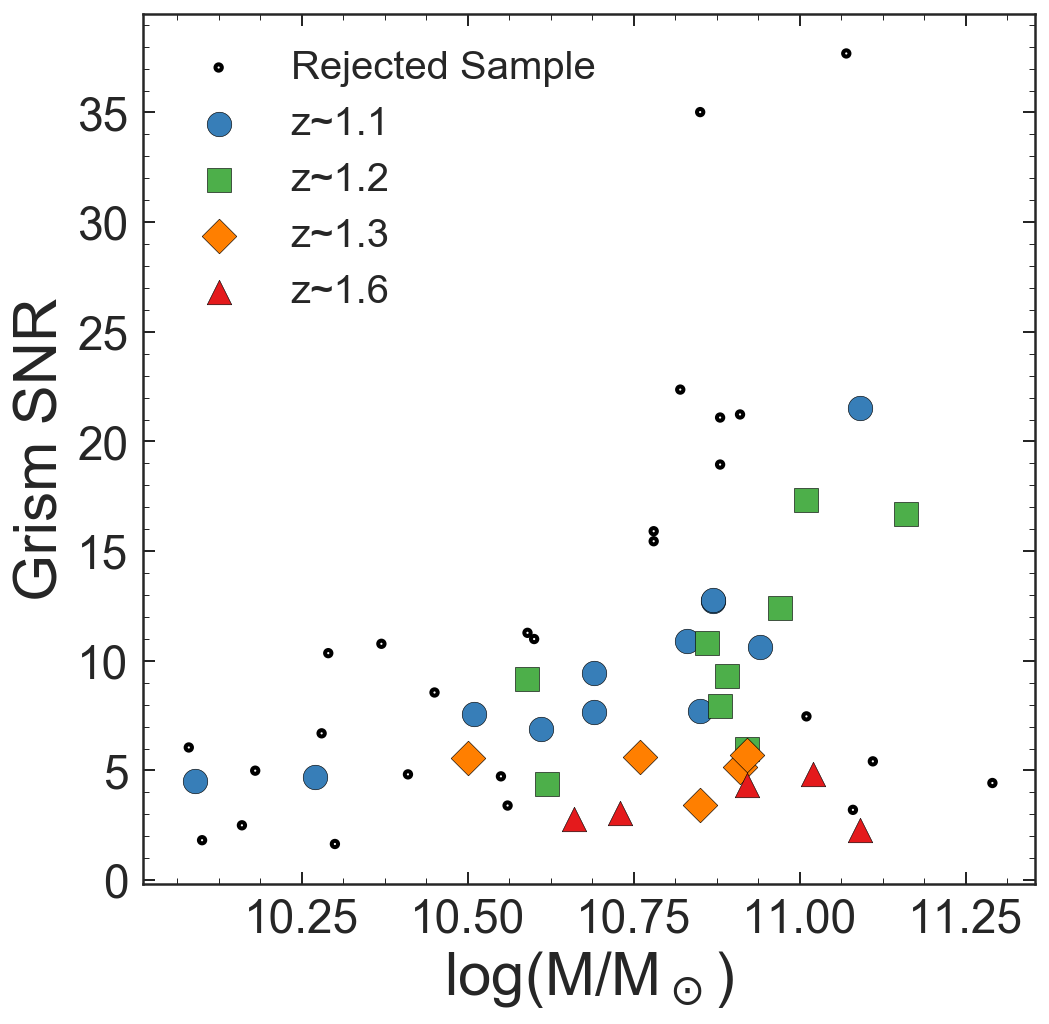

In [65]:
###PLOT
%matplotlib inline
#'#377eb8' '#4daf4a' '#ff7f00' '#e41a1c'
#'o','s','D','^'
plt.figure(figsize=[8,8])
plt.scatter(s_cand.query('goodspec == "out"')['l_mass'],s_cand.query('goodspec == "out"')['SNR'],marker='o', 
            s=10,facecolors='none',edgecolors='k', linewidth=2, zorder=0, label = 'Rejected Sample')
plt.scatter(n_cand.query('goodspec == "out"')['l_mass'],n_cand.query('goodspec == "out"')['SNR'].values,marker='o', 
            s=10,facecolors='none',edgecolors='k', linewidth=2, zorder=0)
plt.scatter(lzDB['l_mass'],lzDB['SNR'],marker='o', s=150,edgecolors='k', color='#377eb8', label = 'z~1.1')
plt.scatter(mzDB['l_mass'],mzDB['SNR'],marker='s', s=150,edgecolors='k',color='#4daf4a', label = 'z~1.2')
plt.scatter(hzDB['l_mass'],hzDB['SNR'],marker='D', s=150,edgecolors='k',color='#ff7f00', label = 'z~1.3')
plt.scatter(uhzDB['l_mass'],uhzDB['SNR'],marker='^', s=150,edgecolors='k',color='#e41a1c', label = 'z~1.6')
plt.legend(loc=2,fontsize=20)
plt.xlabel('log(M/M$_\odot$)',fontsize=30)
plt.ylabel('Grism SNR',fontsize=30)
# plt.ylim(0,23)
plt.tick_params(axis='both', which='major', labelsize=23)
plt.minorticks_on()
plt.savefig('../plots/sn_v_mass_8_13.pdf',bbox_inches = 'tight')

# z$_{phot}$ v z$_{grism}$

In [170]:
s_cand['zgrism'] = np.zeros(len(s_cand))
n_cand['zgrism'] = np.zeros(len(n_cand))

for i in s_cand.index:
    if 's{0}'.format(s_cand.ids[i]) in galDB.gids.values:
        idx = 's{0}'.format(s_cand.ids[i])
        s_cand['zgrism'][i] = galDB.z_grism[galDB.gids == idx].values[0]
    else:
        z,Pz = np.load('../rshift_dat/s{0}_zfit_Pz.npy'.format(s_cand.ids[i]))
        s_cand['zgrism'][i] = z[Pz == max(Pz)][0]

for i in n_cand.index:
    try:
        if 'n{0}'.format(n_cand.ids[i]) in galDB.gids.values:
            idx = 'n{0}'.format(n_cand.ids[i])
            n_cand['zgrism'][i] = galDB.z_grism[galDB.gids == idx].values[0]
        else:
            z,Pz = np.load('../rshift_dat/n{0}_zfit_Pz.npy'.format(n_cand.ids[i]))
            n_cand['zgrism'][i] = z[Pz == max(Pz)][0]
    except:
        print('none')

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
 

none
none


In [66]:
### Data
resS = (s_cand.query('goodspec == "in"')['zgrism'].values - s_cand.query('goodspec == "in"')['zphot'].values)
resN = (n_cand.query('goodspec == "in"')['zgrism'].values - n_cand.query('goodspec == "in"')['zphot'].values)

rejresS = (s_cand.query('goodspec == "out"')['zgrism'].values - s_cand.query('goodspec == "out"')['zphot'].values)
rejresN = (n_cand.query('goodspec == "out"')['zgrism'].values - n_cand.query('goodspec == "out"')['zphot'].values)

mres = np.percentile(np.append(resS,resN),50)
lres = np.percentile(np.append(resS,resN),16)
hres = np.percentile(np.append(resS,resN),84)

zs= np.append(s_cand.query('goodspec == "in"')['zgrism'].values,n_cand.query('goodspec == "in"')['zgrism'].values)
rejzs= np.append(s_cand.query('goodspec == "out"')['zgrism'].values,n_cand.query('goodspec == "out"')['zgrism'].values)
res = np.append(resS,resN)
rejres = np.append(rejresS,rejresN)

In [178]:
n_cand.query('goodspec == "out"')['zgrism'].values

array([1.087, 0.933, 0.932, 0.   , 0.934, 0.94 , 0.849, 0.908, 1.252,
       0.   , 0.854, 0.932, 0.965, 0.932, 0.926, 1.875, 0.94 ])

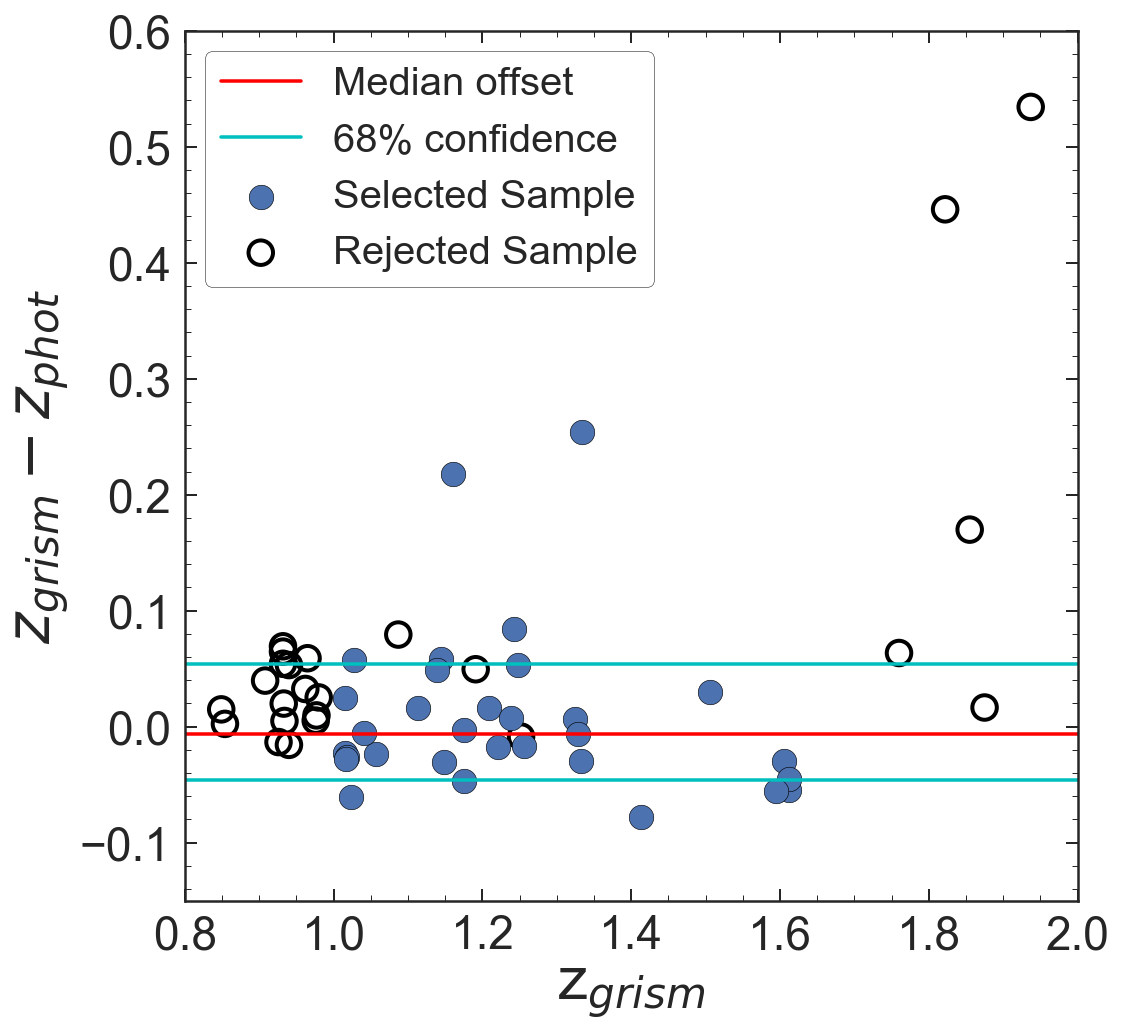

In [68]:
### PLOT 

plt.figure(figsize=[8,8])
plt.scatter(zs,list(res),marker='o', s=150,edgecolors='k',label = 'Selected Sample')
plt.scatter(rejzs,rejres,marker='o',s=150,
            facecolors='none',edgecolors='k', linewidth=2, zorder=0, label = 'Rejected Sample')

plt.axhline(mres,color='r',label = 'Median offset')
plt.axhline(lres,color='c',label = '68% confidence')
plt.axhline(hres,color='c')
plt.xlim(.8,2.0)
plt.ylim(-.15,.6)
plt.ylabel('$z_{grism} - z_{phot}$',fontsize=30)
plt.xlabel('z$_{grism}$',fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=23)
plt.legend(loc=2,fontsize=20,frameon=True,edgecolor='k')
plt.minorticks_on()
plt.savefig('../plots/redshift_diff_8_13.pdf',bbox_inches = 'tight')

# Example spec and LH

In [69]:
### Data
spec = Gen_spec(galDB.gids[2], galDB.z_grism[2],minwv=7800,maxwv=11100)
spec.Fit_lwa(galDB.Z[2],galDB.t[2],galDB.z_grism[2],galDB.d[2],metal,age,tau)
P = np.load('../chidat/n21156_full_fit_tZ_pos.npy')
t,Pt = np.load('../chidat/n21156_full_fit_t_pos.npy')
Z,PZ = np.load('../chidat/n21156_full_fit_Z_pos.npy')
onesig,twosig = Likelihood_contours(age,metal,P)
levels = np.array([twosig,onesig])

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3422: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3427: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3428: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt(self.ivar) < contam_sn_mask[1]))
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: divide by zero encountered in true_divide
  self.op

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


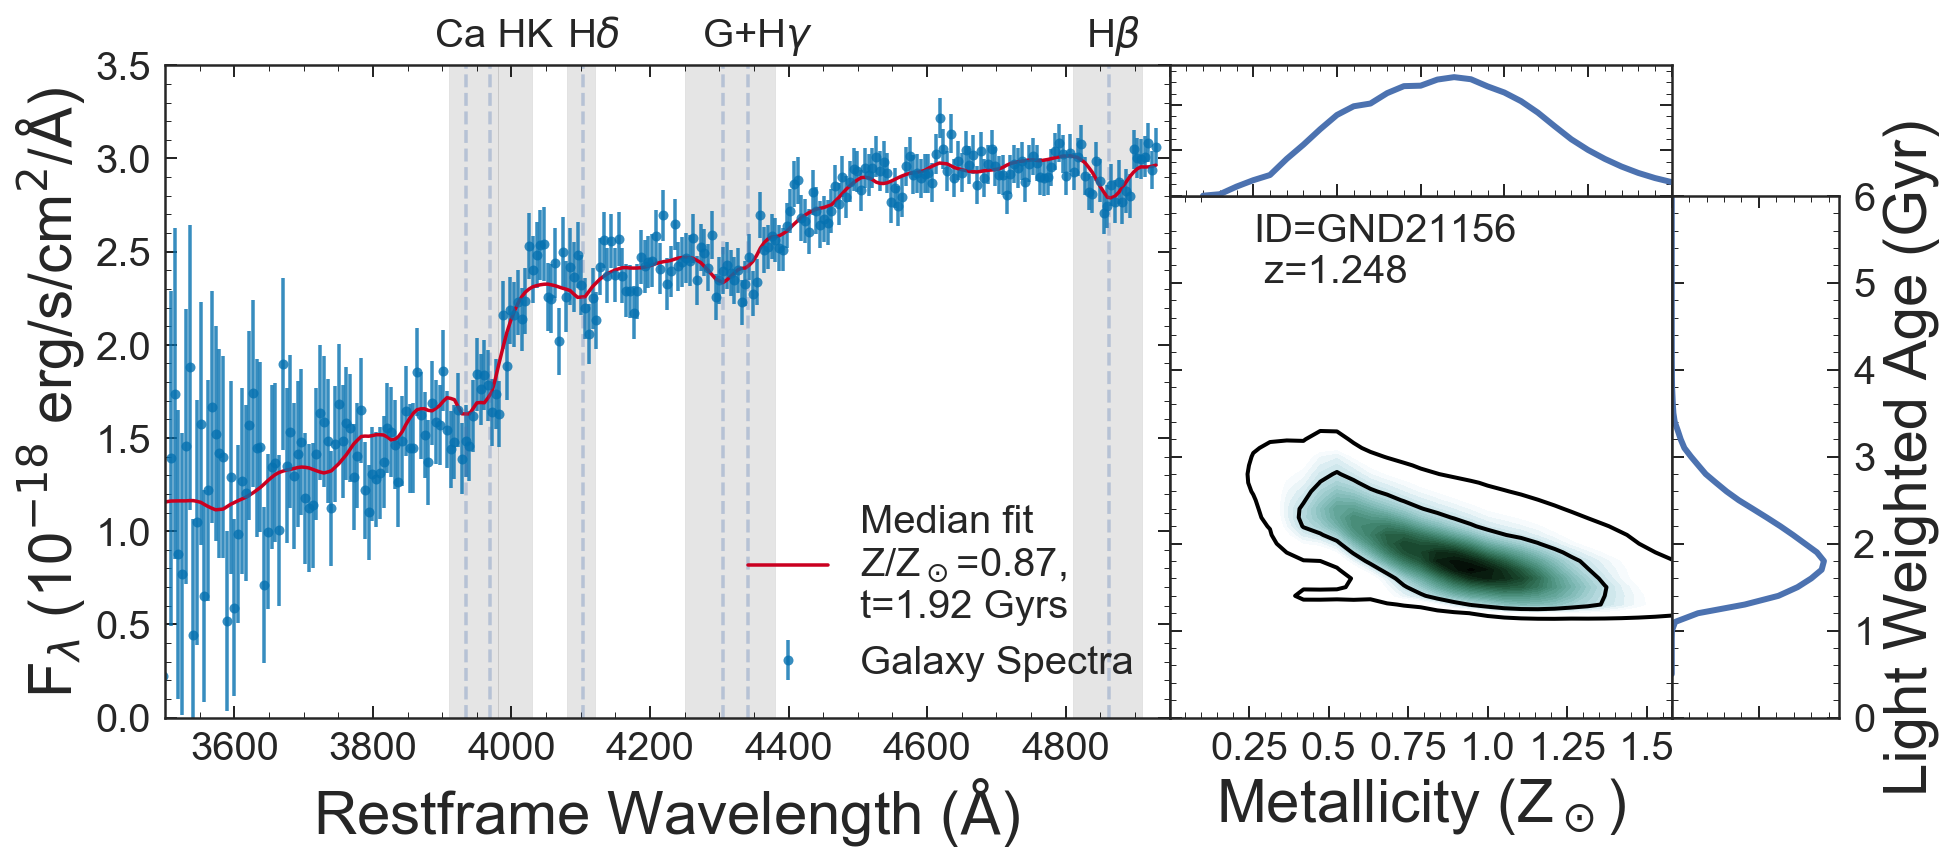

In [71]:
### Plot
%matplotlib inline

gs = gridspec.GridSpec(2,3,height_ratios=[1,4],width_ratios=[6,3,1],hspace=0,wspace=0)

plt.figure(figsize=(15,6))
plt.subplot(gs[0:2,0])
plt.errorbar(spec.gal_wv_rf,spec.gal_fl*1E18,spec.gal_er*1E18,fmt='o',color='#0571b0', alpha = .8,ms=5,label = 'Galaxy Spectra')
plt.plot(spec.gal_wv_rf,spec.fl*1E18, color='#ca0020',
         label='Median fit\nZ/Z$_\odot$=%s,\nt=%s Gyrs' % (np.round(galDB['Zx'][2]/0.019,2),
                                                           np.round(galDB['tx'][2],2)))
plt.axvline(3934.777,linestyle='--', alpha=.3)
plt.axvline(3969.588,linestyle='--', alpha=.3)
plt.axvline(4102.89,linestyle='--', alpha=.3)
plt.axvline(4305.61,linestyle='--', alpha=.3)
plt.axvline(4341.68,linestyle='--', alpha=.3)
plt.axvline(4862.68,linestyle='--', alpha=.3)
plt.axvline(5176.7,linestyle='--', alpha=.3)
plt.axvspan(3910, 3980, color='k', alpha=.1)
plt.axvspan(3980, 4030, color='k', alpha=.1)
plt.axvspan(4080, 4120, color='k', alpha=.1)
plt.axvspan(4250, 4380, color='k', alpha=.1)
plt.axvspan(4810, 4910, color='k', alpha=.1)
plt.axvspan(5120, 5240, color='k', alpha=.1)
plt.text(3890,3.6,'Ca HK',fontsize=20)
plt.text(4080,3.6,'H$\delta$',fontsize=20)
plt.text(4275,3.6,'G+H$\gamma$',fontsize=20)
plt.text(4830,3.6,'H$\\beta$',fontsize=20)
# plt.text(5160,5.6,'Mgb',fontsize=20)
plt.xlim(3500,4950)
plt.ylim(0,3.5)
plt.ylabel('F$_\lambda$ (10$^{-18}$ erg/s/cm$^2$/$\\rm \AA$)',size=30)
plt.xlabel('Restframe Wavelength ($\\rm \AA$)',size=30)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend(loc=4,fontsize=20)
plt.minorticks_on()

plt.subplot(gs[1,1])
plt.contour(M,A,P,levels,colors='k',linewidths=2)
plt.contourf(M,A,P,40,cmap=cmap)
plt.axis([0,0.03,0,6])
plt.xlabel('Metallicity (Z$_\odot$)',size=30)
# plt.ylabel('Light Weighted Age (Gyr)',size=35)
plt.gca().tick_params(axis='y',labelleft='off')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xticks([ 0.00475,  0.0095 ,  0.01425,  0.019  ,  0.02375,  0.0285 ],[0.25,.5,0.75,1.0,1.25,1.5])
plt.text(.005,5,'ID=GND21156\n z=1.248', fontsize=20)

plt.subplot(gs[0,1])
plt.plot(Z,PZ,linewidth=3)
plt.gca().tick_params(axis='y',labelleft='off')
plt.gca().tick_params(axis='x',labelbottom='off')
plt.xlim(0,0.03)
plt.ylim(0,max(PZ)*1.1)

ax = plt.subplot(gs[1,2])
plt.plot(Pt,t,linewidth=3)
plt.gca().tick_params(axis='y',labelleft='off',labelright='on')
plt.ylabel('Light Weighted Age (Gyr)',size=30)
ax.yaxis.set_label_position("right")
plt.gca().tick_params(axis='x',labelbottom='off')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.ylim(0,6)
plt.xlim(0,max(Pt)*1.1)
plt.savefig('../plots/n21156_bf_lh_8_13.pdf',bbox_inches = 'tight')


# Age vs Redshift

In [72]:
def Gen_grid(DB,param):
    grid=[]
    for i in DB.index:
        x,Px = np.load('../chidat/{0}_full_fit_{1}_pos.npy'.format(DB['gids'][i],param))
        grid.append(Px)
    return np.array(grid)

In [73]:
"""DATA"""
rzoo = importr('zoo')

age_range = np.arange(0,3,0.05)

ferrdb = pd.read_pickle('../data/Q_ferreras.pkl')

Pl_grid = Gen_grid(lzDB,'t')
Pm_grid = Gen_grid(mzDB,'t')
Ph_grid = Gen_grid(hzDB,'t')
Puh_grid = Gen_grid(uhzDB,'t')

Pl,Px = Iterative_stacking(Pl_grid,age,1)
Pm,Px = Iterative_stacking(Pm_grid,age,1)
Ph,Px = Iterative_stacking(Ph_grid,age,1)
Puh,Px = Iterative_stacking(Puh_grid,age,1)

lmed,ller,lher=Median_w_Error_cont(Pl,age)
mmed,mler,mher=Median_w_Error_cont(Pm,age)
hmed,hler,hher=Median_w_Error_cont(Ph,age)
uhmed,uhler,uhher=Median_w_Error_cont(Puh,age)

lt=np.array(lzDB['tx'])
mt=np.array(mzDB['tx'])
ht=np.array(hzDB['tx'])
uht=np.array(uhzDB['tx'])
# gmtlt=np.array(gmtlDB['tx'])

fumx,fumy=Readfile('../data/fumagalli_fig14.dat',0)
d,fverr=Readfile('../data/fumagalli_fig14_verr.dat',0)
fherr,d=Readfile('../data/fumagalli_fig14_herr.dat',0)

verr=np.zeros(len(fverr))
herr=np.zeros(len(fherr))
for i in range(len(verr)):
    verr[i]=np.abs(fverr[i]-fumy[i])
    herr[i]=np.abs(fherr[i]-fumx[i])
    
gID,z_g,z_a,redshift,ra,dec,smass,sfr,mWAge,rbWage,metalsSMass = np.loadtxt('../data/millennium2.txt',
                                                                            skiprows=31,delimiter=',').T
mill_DB = pd.DataFrame({'gID':gID,'z_geo':z_g,'z_all':z_a,
                        'redshift':redshift,'ra':ra,'dec':dec,'stellar_mass':smass,'star_formation_rate':sfr,
                       'mass_weighted_age':mWAge,'light_weighted_age':rbWage,'Z_stellar_mass':metalsSMass})
IDW =z_g.argsort()
eres = rzoo.zoo(mill_DB['light_weighted_age'][IDW],mill_DB['z_geo'][IDW])
rmean = rzoo.rollapply(eres,200,'mean', fill = 'NA', align ='right')
rstd = rzoo.rollapply(eres,200,'sd', fill = 'NA', align ='right')

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in add
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in subtract
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in subtract
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in add


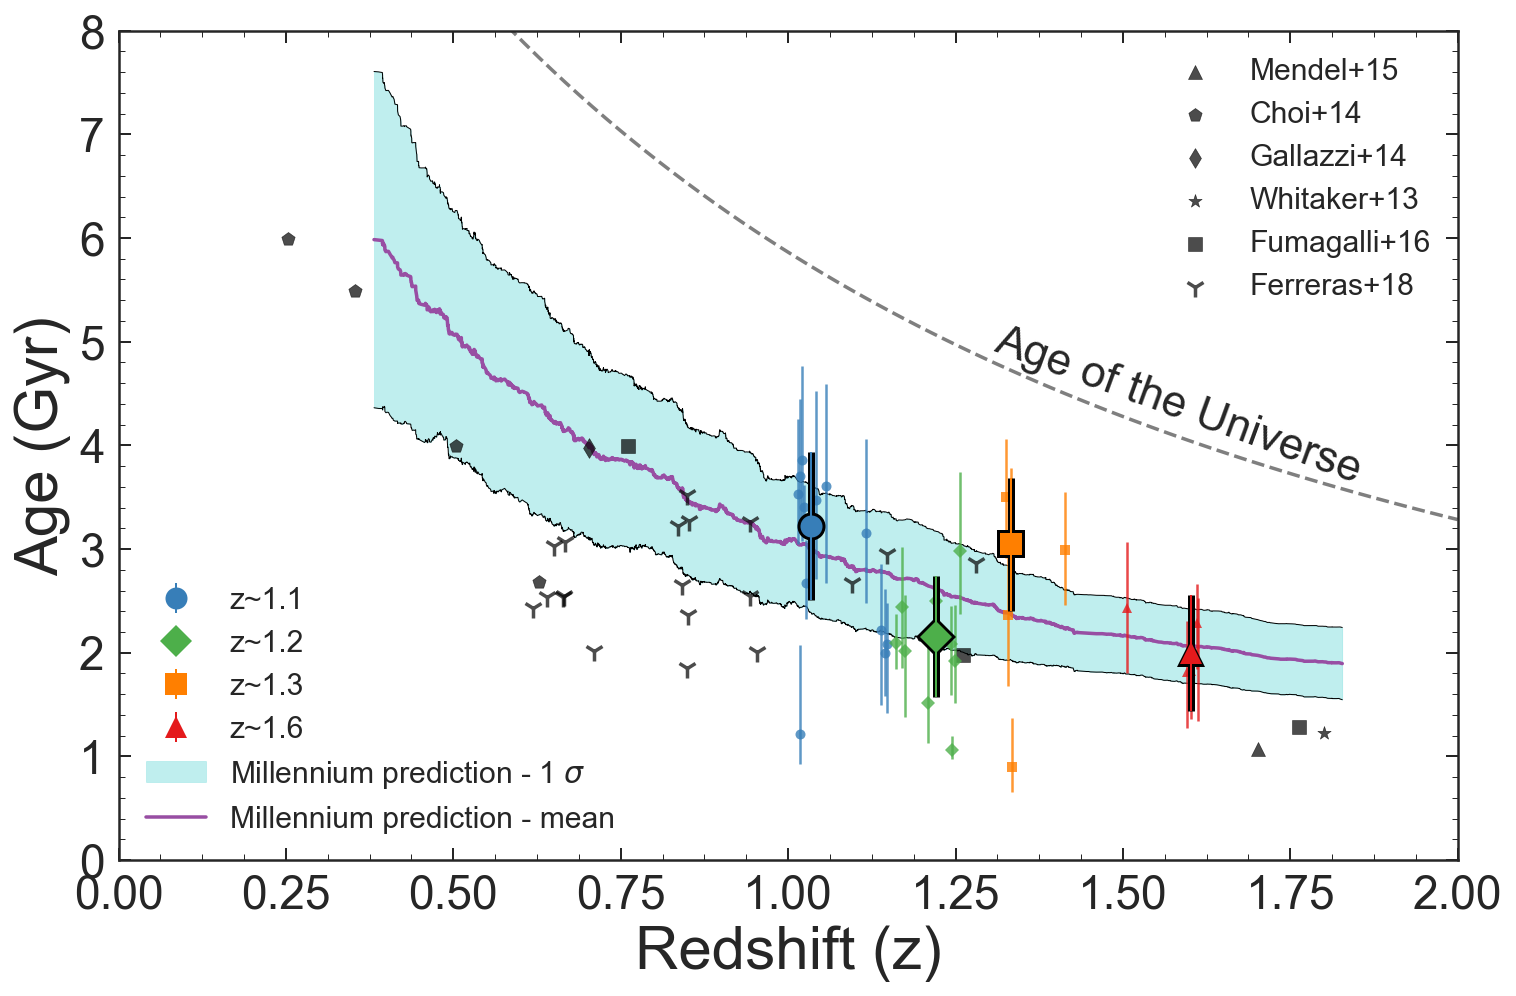

In [75]:
###PLOT
%matplotlib inline

z=np.linspace(0,2,100)
ages=[Oldest_galaxy(a) for a in z]

plt.figure(figsize=[12,8])
currentAxis = plt.gca()
plt.plot(z,ages,'k--',alpha=.5)

ax1=plt.scatter(fumx[9],fumy[9],color = 'k',marker='^',zorder=2,alpha=0.7)         
ax2=plt.scatter(fumx[10:14],fumy[10:14],color = 'k',marker='p',zorder=2,alpha=0.7) 
ax3=plt.scatter(fumx[14],fumy[14],color = 'k',marker='d',zorder=2,alpha=0.7)       
ax4=plt.scatter(fumx[15],fumy[15],color = 'k',marker='*',zorder=2,alpha=0.7)       
ax5=plt.scatter(fumx[6:9],fumy[6:9],color='k',zorder=2,marker='s',alpha=0.7)
ax6=plt.scatter(ferrdb['z'],ferrdb['age'].values,color='k',zorder=2,marker='1',s=100,alpha=0.7)

###allpoints
plt.errorbar(lzDB['z_grism'],lt,yerr=[lzDB['tx_l'],lzDB['tx_h']],
             color='#377eb8',elinewidth=1.25,alpha=.8,ms=5,fmt='o',zorder=3)
plt.errorbar(mzDB['z_grism'],mt,yerr=[mzDB['tx_l'],mzDB['tx_h']],
             color='#4daf4a',elinewidth=1.25,alpha=.8,ms=5,fmt='D',zorder=3)
plt.errorbar(hzDB['z_grism'],ht,yerr=[hzDB['tx_l'],hzDB['tx_h']],
             color='#ff7f00',elinewidth=1.25,alpha=.8,ms=5,fmt='s',zorder=3)
plt.errorbar(uhzDB['z_grism'],uht,yerr=[uhzDB['tx_l'],uhzDB['tx_h']],
             color='#e41a1c',elinewidth=1.25,alpha=.8,ms=5,fmt='^',zorder=3)

####edge
plt.errorbar(np.median(lzDB['z_grism']),lmed,yerr=[[ller,lher]], color='k',elinewidth=3.5,ms=14,fmt='o',zorder=4)
plt.errorbar(np.median(mzDB['z_grism']),mmed,yerr=[[mler,mher]], color='k',elinewidth=3.5,ms=14,fmt='D',zorder=4)
plt.errorbar(np.median(hzDB['z_grism']),hmed,yerr=[[hler,hher]], color='k',elinewidth=3.5,ms=14,fmt='s',zorder=4)
plt.errorbar(np.median(uhzDB['z_grism']),uhmed,yerr=[[uhler,uhher]], color='k',elinewidth=3.5,ms=14,fmt='^',zorder=4)

####face
plt.errorbar(np.median(lzDB['z_grism']),lmed,yerr=[[ller,lher]], color ='#377eb8',elinewidth=1,ms=11,fmt='o',label='z~1.1',zorder=5)
plt.errorbar(np.median(mzDB['z_grism']),mmed,yerr=[[mler,mher]], color='#4daf4a',elinewidth=1,ms=11,fmt='D',label='z~1.2',zorder=5)
plt.errorbar(np.median(hzDB['z_grism']),hmed,yerr=[[hler,hher]], color='#ff7f00',elinewidth=1,ms=11,fmt='s',label='z~1.3',zorder=5)
plt.errorbar(np.median(uhzDB['z_grism']),uhmed,yerr=[[uhler,uhher]], color='#e41a1c',elinewidth=1,ms=11,fmt='^',label='z~1.6',zorder=5)

#### millenium
plt.plot(z_g[IDW],rmean,color = '#984ea3',zorder=1,label = 'Millennium prediction - mean')
plt.plot(z_g[IDW],np.array(rstd) + np.array(rmean),'k',linewidth = .5,zorder=1)
plt.plot(z_g[IDW],np.array(rmean) - np.array(rstd),'k',linewidth = .5,zorder=1)
plt.fill_between(z_g[IDW],np.array(rmean) - np.array(rstd),np.array(rstd) + np.array(rmean),
                color='c',alpha = .25,label = 'Millennium prediction - 1 $\sigma$',zorder=1)

handles, labels = currentAxis.get_legend_handles_labels()
handles = np.array(handles)
labels = np.array(labels)
IDX = np.array([2,3,4,5,1,0])

plt.axis([0.,2.0,0,8])
plt.xlabel('Redshift (z)',size=30)
plt.ylabel('Age (Gyr)',size=30)
plt.tick_params(axis='both', which='major', labelsize=23)
plt.minorticks_on()
plt.text(1.3,4.9,'Age of the Universe',rotation=-20,fontsize=22)
plt.gcf().subplots_adjust(bottom=0.16)
l1= plt.legend([ax1,ax2,ax3,ax4,ax5,ax6],['Mendel+15','Choi+14','Gallazzi+14','Whitaker+13','Fumagalli+16','Ferreras+18'],
              fontsize=15)
plt.legend(handles[IDX], labels[IDX],loc = 3, fontsize=15)
currentAxis.add_artist(l1)
plt.savefig('../plots/agevz_featgroup_all_dt_8_13.pdf',bbox_inches = 'tight')




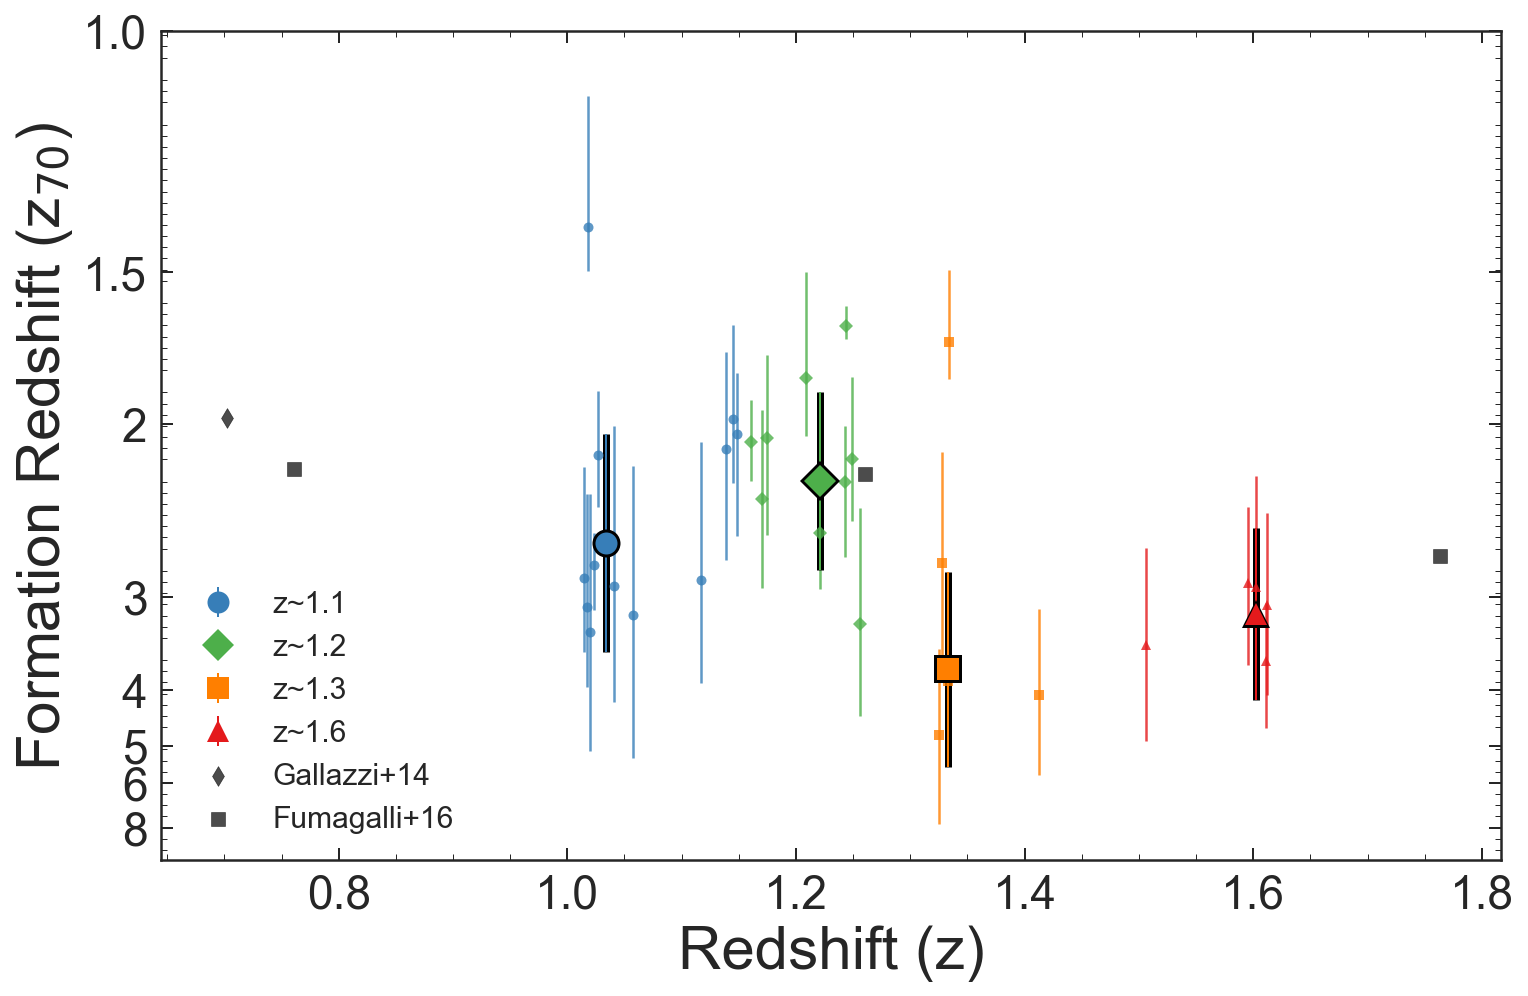

In [81]:
###PLOT
%matplotlib inline

z=np.linspace(0,2,100)
ages=[Oldest_galaxy(a) for a in z]

plt.figure(figsize=[12,8])
currentAxis = plt.gca()
# plt.plot(z,ages,'k--',alpha=.5)

# plt.scatter(fumx[9], Oldest_galaxy(fumx[9]) - fumy[9],color = 'k',marker='^',label='Mendel+15',alpha=0.7)
# plt.scatter(fumx[10:14],Oldest_galaxy(fumx[10:14]) - fumy[10:14],color = 'k',marker='p',label='Choi+14',alpha=0.7)
plt.scatter(fumx[14],Oldest_galaxy(fumx[14]) - fumy[14],color = 'k',marker='d',label='Gallazzi+14',alpha=0.7)
# plt.scatter(fumx[15],Oldest_galaxy(fumx[15]) - fumy[15],color = 'k',marker='*',label='Whitaker+13',alpha=0.7)
plt.scatter(fumx[6:9],Oldest_galaxy(fumx[6:9]) - fumy[6:9],color='k',zorder=2,marker='s',label='Fumagalli+16',alpha=0.7)
# plt.scatter(ferrdb['z'],Oldest_galaxy(ferrdb['z'].values) - ferrdb['age'].values,color='k',zorder=2,marker='1',s=100,label='Ferreras+18',alpha=0.7)

plt.errorbar(lzDB['z_grism'], Oldest_galaxy(lzDB['z_grism']) - lt,
             yerr=[lzDB['tx_l'],lzDB['tx_h']],color='#377eb8',elinewidth=1.25,alpha=.8,ms=5,fmt='o')
plt.errorbar(mzDB['z_grism'],Oldest_galaxy(mzDB['z_grism']) - mt,
             yerr=[mzDB['tx_l'],mzDB['tx_h']],color='#4daf4a',elinewidth=1.25,alpha=.8,ms=5,fmt='D')
plt.errorbar(hzDB['z_grism'],Oldest_galaxy(hzDB['z_grism']) - ht,
             yerr=[hzDB['tx_l'],hzDB['tx_h']],color='#ff7f00',elinewidth=1.25,alpha=.8,ms=5,fmt='s')
plt.errorbar(uhzDB['z_grism'],Oldest_galaxy(uhzDB['z_grism']) - uht,
             yerr=[uhzDB['tx_l'],uhzDB['tx_h']],color='#e41a1c',elinewidth=1.25,alpha=.8,ms=5,fmt='^')

plt.errorbar(np.median(lzDB['z_grism']), Oldest_galaxy(np.median(lzDB['z_grism'])) - lmed,
             yerr=[[ller,lher]], color='k',fmt='o',elinewidth=3.5,ms=14)
plt.errorbar(np.median(mzDB['z_grism']), Oldest_galaxy(np.median(mzDB['z_grism'])) - mmed,
             yerr=[[mler,mher]], color='k',fmt='D',elinewidth=3.5,ms=14)
plt.errorbar(np.median(hzDB['z_grism']), Oldest_galaxy(np.median(hzDB['z_grism'])) - hmed,
             yerr=[[hler,hher]], color='k',fmt='s',elinewidth=3.5,ms=14)
plt.errorbar(np.median(uhzDB['z_grism']), Oldest_galaxy(np.median(uhzDB['z_grism'])) - uhmed,
             yerr=[[uhler,uhher]], color='k',fmt='^',elinewidth=3.5,ms=14)

plt.errorbar(np.median(lzDB['z_grism']), Oldest_galaxy(np.median(lzDB['z_grism'])) - lmed,
             yerr=[[ller,lher]], color='#377eb8',elinewidth=1,ms=11,fmt='o',label='z~1.1')
plt.errorbar(np.median(mzDB['z_grism']), Oldest_galaxy(np.median(mzDB['z_grism'])) - mmed,
             yerr=[[mler,mher]], color='#4daf4a',elinewidth=1,ms=11,fmt='D',label='z~1.2')
plt.errorbar(np.median(hzDB['z_grism']), Oldest_galaxy(np.median(hzDB['z_grism'])) - hmed,
             yerr=[[hler,hher]], color='#ff7f00',elinewidth=1,ms=11,fmt='s',label='z~1.3')
plt.errorbar(np.median(uhzDB['z_grism']), Oldest_galaxy(np.median(uhzDB['z_grism'])) - uhmed,
             yerr=[[uhler,uhher]], color='#e41a1c',elinewidth=1,ms=11,fmt='^',label='z~1.6')

# currentAxis.add_patch(Rectangle((np.median(lzDB['hi_res_specz'])-0.05, 
#                                  Oldest_galaxy(np.median(lzDB['hi_res_specz'])) - lmed)
#                                 ,0.1,lmed-lmed_d,fill=False ,edgecolor='k', zorder=2,
#                                 label='Dust Bound',linewidth=2,linestyle='dashed'))
# currentAxis.add_patch(Rectangle((np.median(mzDB['hi_res_specz'])-0.05, 
#                                  Oldest_galaxy(np.median(mzDB['hi_res_specz'])) - mmed)
#                                 ,0.1,mmed-mmed_d,fill=False ,edgecolor='k',zorder=2,linewidth=2,linestyle='dashed'))
# currentAxis.add_patch(Rectangle((np.median(hzDB['hi_res_specz'])-0.05,
#                                  Oldest_galaxy(np.median(hzDB['hi_res_specz'])) - hmed)
#                                 ,0.1,hmed-hmed_d,fill=False ,edgecolor='k',zorder=2,linewidth=2,linestyle='dashed'))
# currentAxis.add_patch(Rectangle((np.median(uhzDB['hi_res_specz'])-0.05,
#                                  Oldest_galaxy(np.median(uhzDB['hi_res_specz'])) - uhmed)
#                                 ,0.1,uhmed-uhmed_d,fill=False ,edgecolor='k', zorder=2,linewidth=2,linestyle='dashed'))

handles, labels = currentAxis.get_legend_handles_labels()
handles = np.array(handles)
labels = np.array(labels)
IDX = np.array([2,3,4,5,0,1])

plt.xlabel('Redshift (z)',size=30)
plt.ylabel('Formation Redshift (z$_{70}$)',size=30)
plt.yticks([0.6389,0.9315,1.1735,1.5413,2.1489,3.2845,4.278,5.863],[8,6,5,4,3,2,1.5,1.0])
plt.tick_params(axis='both', which='major', labelsize=23)
plt.minorticks_on()
plt.gcf().subplots_adjust(bottom=0.16)
plt.legend(handles[IDX], labels[IDX],loc=3,fontsize=15)
# plt.savefig('../plots/agevz_rshift_all_dt_2-27.pdf',bbox_inches = 'tight')

# Mass Metallicity

In [82]:
"""DATA"""
gmtlDB = galDB

Pl_grid = Gen_grid(lzDB,'Z')
Pm_grid = Gen_grid(mzDB,'Z')
Ph_grid = Gen_grid(hzDB,'Z')
Puh_grid = Gen_grid(uhzDB,'Z')

Pl,Px = Iterative_stacking(Pl_grid,metal,3,extend=True)
Pm,Px = Iterative_stacking(Pm_grid,metal,3,extend=True)
Ph,Px = Iterative_stacking(Ph_grid,metal,3,extend=True)
Puh,Px = Iterative_stacking(Puh_grid,metal,3,extend=True)

lmed,ller,lher=Median_w_Error_cont(Pl,metal)
mmed,mler,mher=Median_w_Error_cont(Pm,metal)
hmed,hler,hher=Median_w_Error_cont(Ph,metal)
uhmed,uhler,uhher=Median_w_Error_cont(Puh,metal)

logm,gmetal=Readfile('../data/Gallazzi_12.dat',0)
cvx,cvy=Readfile('../data/Gallazzi_12_line.dat',0)
cv1x,cv1y=Readfile('../data/gallazzi_points_curve1.dat',0)

lZ=np.array(lzDB['Zx'])
mZ=np.array(mzDB['Zx'])
hZ=np.array(hzDB['Zx'])
uhZ=np.array(uhzDB['Zx'])
gmtlZ=np.array(gmtlDB['Zx'])

lerrs = gmtlDB['Zx_l']/(gmtlDB['Zx'] * np.log(10))
herrs = gmtlDB['Zx_h']/(gmtlDB['Zx'] * np.log(10))
errs = ((gmtlDB['Zx_l'] + gmtlDB['Zx_h'])/2) / (gmtlDB['Zx'] * np.log(10))
samp = np.arange(10,11.8,.01)
lfit,lfit_errs,cov = Linear_fit(gmtlDB['l_mass'],np.log10(gmtlZ/0.019),errs,samp,return_cov=True)

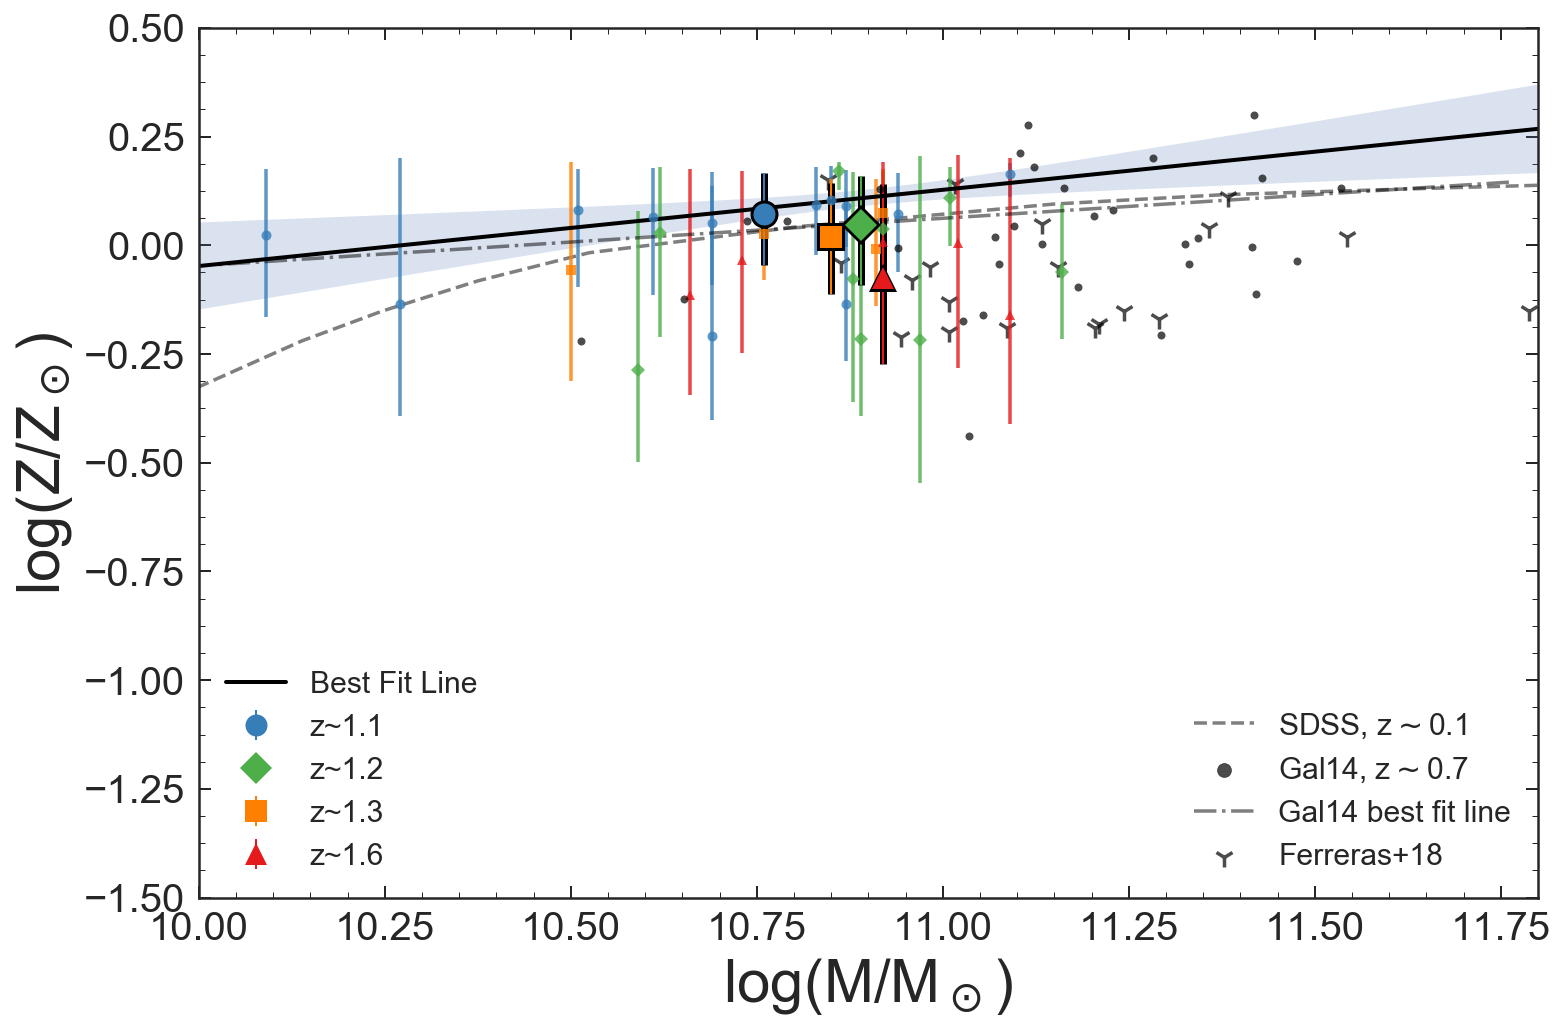

In [84]:
###PLOT
%matplotlib inline

plt.figure(figsize=[12,8])
currentAxis = plt.gca()

####gallazzi points
plt.plot(cv1x,cv1y,'--',zorder=1,color='k',alpha=.5,markersize=4)
sdss=plt.axhline(y=5,linestyle='--',color='k',alpha=.5)
plt.plot(cvx,cvy,zorder=2,linestyle='-.',color='k',alpha=.5,ms=4)
galbf=plt.axhline(y=5,linestyle='-.',color='k',alpha=.5)
plt.plot(logm,gmetal,'o',zorder=3,color='k',alpha=.7,markersize=4)
galpts = plt.scatter(100,100,marker='o',zorder=3,color='k',alpha=.7)#,label='Gallazzi+14,z=0.7')
#####ferreras points
ferra = plt.scatter(np.log10(ferrdb['M']*1E11),ferrdb['Z/H'].values,color='k',zorder=2,marker='1',alpha=.7,s=100,label='Ferreras+18')
legend1 = plt.legend([sdss,galpts,galbf,ferra],
                     ['SDSS, z$\sim$0.1','Gal14, z$\sim$0.7','Gal14 best fit line','Ferreras+18'],
                     loc = 4,fontsize=15)
currentAxis.add_artist(legend1)
#####single galaxy points
plt.errorbar(lzDB['l_mass'],np.log10(lZ/0.019), yerr=[lzDB['Zx_l']/(lzDB['Zx'] * np.log(10)),
            lzDB['Zx_h']/(lzDB['Zx'] * np.log(10))],color='#377eb8',alpha=.8,ms=5,fmt='o')
plt.errorbar(mzDB['l_mass'],np.log10(mZ/0.019), yerr=[mzDB['Zx_l']/(mzDB['Zx'] * np.log(10)),
            mzDB['Zx_h']/(mzDB['Zx'] * np.log(10))],color='#4daf4a',alpha=.8,ms=5,fmt='D')
plt.errorbar(hzDB['l_mass'],np.log10(hZ/0.019), yerr=[hzDB['Zx_l']/(hzDB['Zx'] * np.log(10)),
            hzDB['Zx_h']/(hzDB['Zx'] * np.log(10))],color='#ff7f00',alpha=.8,ms=5,fmt='s')
plt.errorbar(uhzDB['l_mass'],np.log10(uhZ/0.019), yerr=[uhzDB['Zx_l']/(uhzDB['Zx'] * np.log(10)),
            uhzDB['Zx_h']/(uhzDB['Zx'] * np.log(10))],color='#e41a1c',alpha=.8,ms=5,fmt='^')

### best fit line
plt.plot(samp,lfit,'k',linewidth=2,label ='Best Fit Line')
plt.fill_between(samp,lfit - lfit_errs,lfit + lfit_errs,alpha = .2,label = '68% Conifidence Interval')


#### edge
plt.errorbar(np.median(lzDB['l_mass']),np.log10(lmed/0.019), 
             yerr=[[ller/(lmed * np.log(10))],[lher/(lmed * np.log(10))]],color='k',ms=14,fmt='o',elinewidth=3.5)
plt.errorbar(np.median(mzDB['l_mass']),np.log10(mmed/0.019),  
             yerr=[[mler/(mmed * np.log(10))],[mher/(mmed * np.log(10))]],color='k',ms=14,fmt='D',elinewidth=3.5)
plt.errorbar(np.median(hzDB['l_mass']),np.log10(hmed/0.019),  
             yerr=[[hler/(hmed * np.log(10))],[hher/(hmed * np.log(10))]],color='k',ms=14,fmt='s',elinewidth=3.5)
plt.errorbar(np.median(uhzDB['l_mass']),np.log10(uhmed/0.019),  
             yerr=[[uhler/(uhmed * np.log(10))],[uhher/(uhmed * np.log(10))]],color='k',ms=14,fmt='^',elinewidth=3.5)
#### face
plt.errorbar(np.median(lzDB['l_mass']),np.log10(lmed/0.019), yerr=[[ller/(lmed * np.log(10))],
            [lher/(lmed * np.log(10))]], color='#377eb8',elinewidth=1,ms=11,fmt='o',label='z~1.1')
plt.errorbar(np.median(mzDB['l_mass']),np.log10(mmed/0.019),  yerr=[[mler/(mmed * np.log(10))],
            [mher/(mmed * np.log(10))]], color='#4daf4a',elinewidth=1,ms=11,fmt='D',label='z~1.2')
plt.errorbar(np.median(hzDB['l_mass']),np.log10(hmed/0.019),  yerr=[[hler/(hmed * np.log(10))],
            [hher/(hmed * np.log(10))]], color='#ff7f00',elinewidth=1,ms=11,fmt='s',label='z~1.3')
plt.errorbar(np.median(uhzDB['l_mass']),np.log10(uhmed/0.019),  yerr=[[uhler/(uhmed * np.log(10))],
            [uhher/(uhmed * np.log(10))]], color='#e41a1c',elinewidth=1,ms=11,fmt='^',label='z~1.6')

# plt.plot(samp,0.1616*samp11 + 0.0867,'r')

handles, labels = currentAxis.get_legend_handles_labels()
handles = np.array(handles)
labels = np.array(labels)
IDX = np.array([0,3,4,5,6])

plt.xlabel('log(M/M$_\odot$)',size=30)
plt.ylabel('log(Z/Z$_\odot$)',size=30)
plt.axis([10,11.8,-1.5,.5])
plt.tick_params(axis='both', which='major', labelsize=20)
currentAxis.xaxis.set_minor_locator(plt.MultipleLocator(0.05))
# plt.minorticks_on()

plt.legend(handles[IDX], labels[IDX],loc=3,fontsize=15)
plt.savefig('../plots/metalmass_featgroup_8_13.pdf',bbox_inches = 'tight')

# Stacks

In [13]:
3.3 \pm 0.7
2.2 \pm 0.6
3.1 \pm 0.6
2.0 \pm 0.6

9.954242509439325

In [ ]:
\zone &$1.21_{-0.37}^{+0.21}$ & $3.3 \pm 0.7$ & 10.1--11.1  & 12\\
\ztwo &$1.16_{-0.35}^{+0.29}$&$2.2 \pm 0.6$   & 10.6--11.2 & 9\\
\zthree &$1.05_{-0.32}^{+0.30}$&$3.1 \pm 0.6$ & 10.5--11.0 & 5 \\
\zsix &$0.84_{-0.38}^{+0.42}$&$2.0 \pm 0.6$  & 10.7--11.1 & 5\\

In [40]:
np.array([0.01597194388777555, 0.0072384769539078145, 0.007967935871743485])/0.019

array([0.84062863, 0.38097247, 0.41936505])

In [46]:
Median_w_Error_cont(PTuh,age)

(1.9989979959919841, 0.5621242484969939, 0.6062124248496992)

In [23]:
"""DATA"""

PZl_grid = Gen_grid(lzDB,'Z')
PZm_grid = Gen_grid(mzDB,'Z')
PZh_grid = Gen_grid(hzDB,'Z')
PZuh_grid = Gen_grid(uhzDB,'Z')

PTl_grid = Gen_grid(lzDB,'t')
PTm_grid = Gen_grid(mzDB,'t')
PTh_grid = Gen_grid(hzDB,'t')
PTuh_grid = Gen_grid(uhzDB,'t')

PDl_grid = Gen_grid(lzDB,'d')
PDm_grid = Gen_grid(mzDB,'d')
PDh_grid = Gen_grid(hzDB,'d')
PDuh_grid = Gen_grid(uhzDB,'d')

PZl,wPZl = Iterative_stacking(PZl_grid,metal,3,extend=True)
PZm,wPZm = Iterative_stacking(PZm_grid,metal,3,extend=True)
PZh,wPZh = Iterative_stacking(PZh_grid,metal,3,extend=True)
PZuh,wPZuh = Iterative_stacking(PZuh_grid,metal,3,extend=True)

PTl,wPTl = Iterative_stacking(PTl_grid,age,1)
PTm,wPTm = Iterative_stacking(PTm_grid,age,1)
PTh,wPTh = Iterative_stacking(PTh_grid,age,1)
PTuh,wPTuh = Iterative_stacking(PTuh_grid,age,1)

PDl,PDx = Iterative_stacking(PDl_grid,dust,1)
PDm,PDx = Iterative_stacking(PDm_grid,dust,1)
PDh,PDx = Iterative_stacking(PDh_grid,dust,1)
PDuh,PDx = Iterative_stacking(PDuh_grid,dust,1)

Zmedl, Zler, Zher = np.round(Median_w_Error(PZl,metal),3)
Zmedm, Zler, Zher = np.round(Median_w_Error(PZm,metal),3)
Zmedh, Zler, Zher = np.round(Median_w_Error(PZh,metal),3)
Zmeduh, Zler, Zher = np.round(Median_w_Error(PZuh,metal),3)
tmedl, tler, ther = np.round(Median_w_Error(PTl,age),1)
tmedm, tler, ther = np.round(Median_w_Error(PTm,age),1)
tmedh, tler, ther = np.round(Median_w_Error(PTh,age),1)
tmeduh, tler, ther = np.round(Median_w_Error(PTuh,age),1)
dmedl, dler, dher = np.round(Median_w_Error(PDl,dust),1)
dmedm, dler, dher = np.round(Median_w_Error(PDm,dust),1)
dmedh, dler, dher = np.round(Median_w_Error(PDh,dust),1)
dmeduh, dler, dher = np.round(Median_w_Error(PDuh,dust),1)

lzstack = Stack(lzDB['gids'].values,lzDB['z_grism'].values,np.arange(3400,5500,10),np.arange(4000,5200,1))
lzstack.Stack_normwmean()
lzstack.Fit_lwa(Zmedl,tmedl,dmedl,metal,age,tau)

mzstack = Stack(mzDB['gids'].values,mzDB['z_grism'].values,np.arange(3400,5300,10),np.arange(3750,4950,1))
mzstack.Stack_normwmean()
mzstack.Fit_lwa(Zmedm,tmedm,dmedm,metal,age,tau)

hzstack = Stack(hzDB['gids'].values,hzDB['z_grism'].values,np.arange(3350,5300,10),np.arange(3475,4600,1))
hzstack.Stack_normwmean()
hzstack.Fit_lwa(Zmedh,tmedh,dmedh,metal,age,tau)

uhzstack = Stack(uhzDB['gids'].values,uhzDB['z_grism'].values,np.arange(3075,4450,10),np.arange(3400,4200,1))
uhzstack.Stack_normwmean()
uhzstack.Fit_lwa(Zmeduh,tmeduh,dmeduh,metal,age,tau)


In [15]:
"""PLOT"""
def Plot_stack(wv,fl,er,mwv,mfl,bfm,bfa,adist,A,mdist,M,wadist,wmdist,window=[],group='',group_win=[],save_plot=False,plot_name=''):
    
    gs = gridspec.GridSpec(2,2,hspace=0,wspace=0,width_ratios=[3,1])
    
    plt.figure(figsize=[15,7])
    plt.subplot(gs[0:,0])
    plt.errorbar(wv,fl * 1000,er * 1000,color='#0571b0',fmt='o',ms = 4,elinewidth=2)
    plt.plot(mwv,mfl * 1000,color='#ca0020',label='Z=%s Z$_\odot$,t=%s Gyrs' % (np.round(bfm/0.019,2),bfa),zorder = 5,linewidth = 2)
    plt.axvline(3934.777,linestyle='--', alpha=.3)
    plt.axvline(3969.588,linestyle='--', alpha=.3)
    plt.axvline(4102.89,linestyle='--', alpha=.3)
    plt.axvline(4305.61,linestyle='--', alpha=.3)
    plt.axvline(4341.68,linestyle='--', alpha=.3)
    plt.axvline(4862.68,linestyle='--', alpha=.3)
    plt.axvline(5176.7,linestyle='--', alpha=.3)
    plt.axvspan(3910, 3980, color='k', alpha=.1)
    plt.axvspan(3980, 4030, color='k', alpha=.1)
    plt.axvspan(4080, 4120, color='k', alpha=.1)
    plt.axvspan(4250, 4380, color='k', alpha=.1)
    plt.axvspan(4810, 4910, color='k', alpha=.1)
    plt.axvspan(5120, 5240, color='k', alpha=.1)
    plt.text(3900,window[3]+.05,'Ca HK',fontsize=15)
    plt.text(4080,window[3]+.05,'H$\delta$',fontsize=15)
    plt.text(group_win[0],group_win[1],group,fontsize=25,backgroundcolor=[.3,.3,.3],color='w')
  
    if window[1] > 4250:
        plt.text(4280,window[3]+.05,'G+H$\gamma$',fontsize=15)
    if window[1] > 4800:
        plt.text(4830,window[3]+.05,'H$\\beta$',fontsize=15)
    if window[1] > 5100:
        plt.text(5160,window[3]+.05,'Mgb',fontsize=15)
    
    plt.axis(window)
    plt.ylabel('F$_\lambda$',size=20)
    plt.xlabel('Restframe Wavelength ($\\rm \AA$)',size=20)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.gcf().subplots_adjust(bottom=0.235)
    plt.legend(loc=4,fontsize=20)
    plt.minorticks_on()
        
    ax = plt.subplot(gs[0,1])
    plt.plot(age,wadist,label = 'P$^*$(t)',color='#377eb8',linewidth=3)
    plt.plot(A,adist,label = 'P(t)',color='#e41a1c',linewidth=3)
    plt.tick_params(axis='both', which='major', labelsize=15)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 
    plt.xlim(min(age),max(age))
    plt.ylim(0,max(adist)*1.1)
    plt.xlabel('Age (Gyr)',size=20)
    plt.yticks([])
    plt.legend(fontsize=14)
    
    plt.subplot(gs[1,1])
    plt.plot(metal,wmdist,label = 'P$^*$(Z)',color='#377eb8',linewidth=3)
    plt.plot(M,mdist,label = 'P(Z)',color='#e41a1c',linewidth=3)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.xticks([0.00475, 0.0095, 0.01425, 0.019, 0.02375, 0.0285],
           np.round(np.array([0.00475, 0.0095, 0.01425, 0.019, 0.02375, 0.0285])/0.019, 2))    
    plt.xlabel('Metallicity (Z$_\odot$)',size=20)
    plt.xlim(min(metal),max(metal))
    plt.ylim(0,max(mdist)*1.1)
    plt.yticks([])
    plt.legend(fontsize=14)
    
    if save_plot == True:
        plt.savefig(plot_name,bbox_inches = 'tight')

In [55]:
Plot_stack(lzstack.wv,lzstack.fl,lzstack.er,lzstack.mwv,lzstack.mfl,Zmedl,tmedl,PTl,age,PZl,metal,wPTl,wPZl,
           window=[3800,5300,.2,1.1],group='z~1.1',group_win=[3850,0.9],save_plot=True,
           plot_name='../plots/stack_lz_bf_8-13.pdf')

Plot_stack(mzstack.wv,mzstack.fl,mzstack.er,mzstack.mwv,mzstack.mfl,Zmedm,tmedm,PTm,age,PZm,metal,wPTm,wPZm,
           window=[3600,4950,0,1.2],group='z~1.2',group_win=[3650,0.85],save_plot=True,
           plot_name='../plots/stack_mz_bf_8-13.pdf')

Plot_stack(hzstack.wv,hzstack.fl,hzstack.er,hzstack.mwv,hzstack.mfl,Zmedh,tmedh,PTh,age,PZh,metal,wPTh,wPZh,
           window=[3400,4790,0,1.6],group='z~1.3',group_win=[3450,1.2],save_plot=True,
           plot_name='../plots/stack_hz_bf_8-13.pdf')

Plot_stack(uhzstack.wv,uhzstack.fl,uhzstack.er,uhzstack.mwv,uhzstack.mfl,Zmeduh,tmeduh,PTuh,age,PZuh,metal,wPTuh,wPZuh,
           window=[3100,4250,0.,2.5],group='z~1.6',group_win=[3150,1.9],save_plot=True,
            plot_name='../plots/stack_uhz_bf_8-13.pdf')

NameError: name 'Plot_stack' is not defined

In [30]:
galDB.sort_values('z_grism')

,gids,z_grism,z_grism_+,z_grism_-,Z,Z_l,Z_h,Zx,Zx_l,Zx_h,...,taux_l,taux_h,d,d_l,d_h,dx,dx_l,dx_h,l_mass,SNR
0,n16758,1.015,0.003,0.004,0.024,0.007,0.004,0.023547,0.006228,0.004657,...,0.217872,0.229976,0.1,0.084,0.038,0.058116,0.042084,0.080160,10.83,10.905958
14,s39241,1.017,0.003,0.002,0.024,0.006,0.004,0.023435,0.005106,0.004433,...,0.187612,0.217872,0.2,0.130,0.071,0.160321,0.090180,0.110220,10.87,12.732119
24,s42221,1.018,0.112,0.008,0.023,0.009,0.005,0.022874,0.009315,0.004994,...,0.187612,0.665721,0.2,0.128,0.169,0.194389,0.122244,0.174349,10.51,7.575737
25,s43615,1.020,0.004,0.007,0.022,0.008,0.005,0.021415,0.007014,0.005780,...,0.187612,0.248132,0.5,0.183,0.175,0.478958,0.162325,0.196393,10.69,7.645023
13,s39170,1.023,0.001,0.002,0.028,0.004,0.001,0.027643,0.003255,0.001739,...,0.211820,0.096832,0.1,0.090,-0.024,0.036072,0.026052,0.040080,11.09,21.512867
9,n37955,1.027,0.005,0.008,0.025,0.010,0.003,0.024108,0.009202,0.004377,...,0.314704,0.211820,0.7,0.313,0.156,0.631263,0.244489,0.224449,10.85,7.722264
28,s45972,1.041,0.004,0.004,0.014,0.004,0.008,0.013896,0.004152,0.007631,...,0.181560,0.248132,0.1,0.080,0.052,0.070140,0.050100,0.084168,10.87,12.760478
15,s39631,1.057,0.007,0.021,0.012,0.005,0.009,0.011764,0.005218,0.009315,...,0.169456,0.242080,0.2,0.120,0.109,0.186373,0.106212,0.122244,10.69,9.434903
30,s47677,1.117,0.006,0.011,0.020,0.009,0.007,0.020012,0.008641,0.007014,...,0.199716,0.260236,0.3,0.176,0.191,0.282565,0.158317,0.208417,10.09,4.503832
4,n23435,1.139,0.012,0.012,0.014,0.008,0.011,0.013896,0.008192,0.010774,...,0.242080,0.338912,0.4,0.218,0.255,0.384770,0.202405,0.270541,10.27,4.719428


In [32]:
print(galDB.Zx[30]/0.019,(galDB.Zx_l[30]+galDB.Zx_h[30])/0.019)
print(galDB.tx[30],(galDB.tx_l[30]+galDB.tx_h[30]))

1.05326442358401 0.8239637169074991
3.156312625250501 1.5761523046092192


In [36]:
print(galDB.Zx[4]/0.019,(galDB.Zx_l[4]+galDB.Zx_h[4])/0.019)
print(galDB.tx[4],(galDB.tx_l[4]+galDB.tx_h[4]))

0.7313574517455964 0.9982069401961817
2.219438877755511 1.366733466933868


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


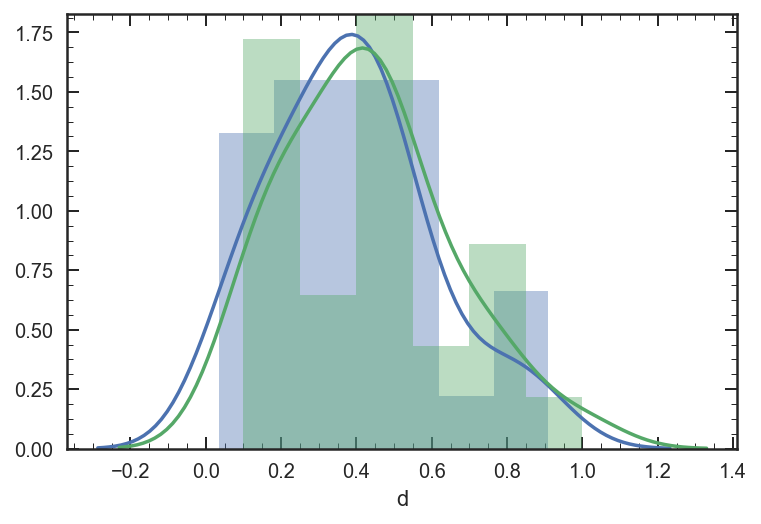

In [44]:
sea.distplot(galDB.dx)
sea.distplot(galDB.d)

In [41]:
galDB.dx

0     0.058116
1     0.138277
2     0.368737
3     0.432866
4     0.384770
5     0.909820
6     0.352705
7     0.260521
8     0.537074
9     0.631263
10    0.799599
11    0.282565
12    0.428858
13    0.036072
14    0.160321
15    0.186373
16    0.326653
17    0.396794
18    0.494990
19    0.517034
20    0.176353
21    0.390782
22    0.482966
23    0.793587
24    0.194389
25    0.478958
26    0.314629
27    0.615230
28    0.070140
29    0.474950
30    0.282565
Name: dx, dtype: float64

In [14]:
np.mean((galDB.tx_l + galDB.tx_h))

1.1071821061477793

In [16]:
np.median((galDB.Zx_l + galDB.Zx_h))/0.019

0.7353654677776605

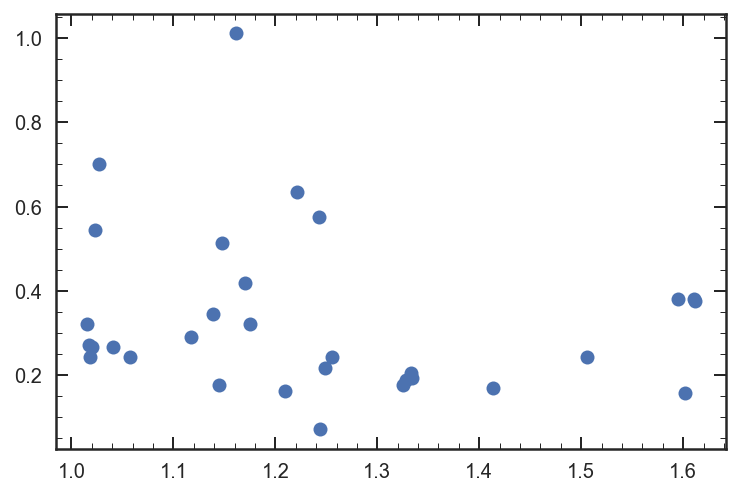

In [85]:
plt.plot(galDB.z_grism,galDB.taux,'o')

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


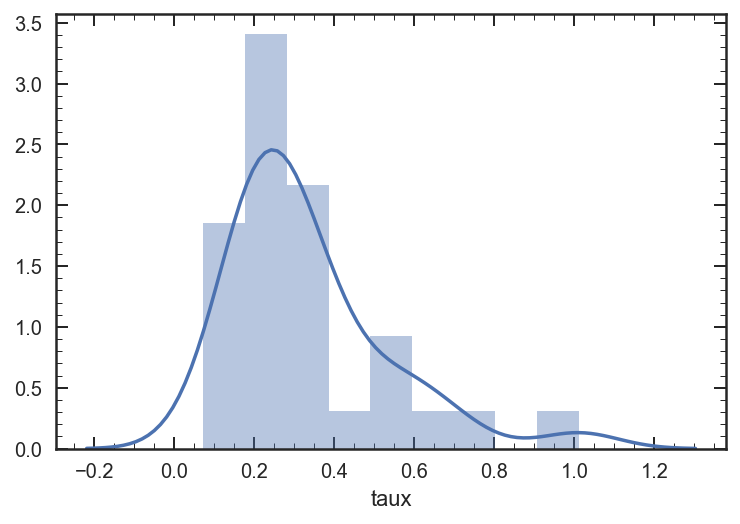

In [86]:
sea.distplot(galDB.taux)